<a href="https://colab.research.google.com/github/dsgustavomoreira/Geracao-imagens-com-GANs/blob/main/Gera%C3%A7%C3%A3o_de_imagens_com_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geração de imagens com  - Estudo

Código adaptado da documentação: https://www.tensorflow.org/beta/tutorials/generative/dcgan

# Etapa 1: Importação das bibliotecas

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import os
import PIL
import time

# Etapa 2: Importação e tratamento da base de dados

In [2]:
# Apenas estamos carregando as imagens de treino, por isso '(_,_)', uma vez que o teste será visual
(train_images, train_labels), (_,_) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [3]:
train_images.shape

(60000, 28, 28)

In [4]:
train_labels.shape

(60000,)

In [5]:
# convertendo para float 32, adicionando um canal, indicando que estamos trabalhando com as imagens em escala de cinza
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [6]:
train_images.shape

(60000, 28, 28, 1)

In [7]:
# Normalização entre -1 e 1
train_imagens = (train_images - 127.5) / 127.5

In [8]:
# batch_size é a quantidade de imagens 'por lote'
buffer_size = 60000
batch_size = 256

In [9]:
# Convertendo para o formato do tensorflow
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

In [10]:
# tensor_slices faz batchs: 60000(imagens) / 256(batchs=qtde de imagens por lote) = 234 slices e dentro de cada slice tem 256 imagens
train_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Etapa 3: Visualização dos dados

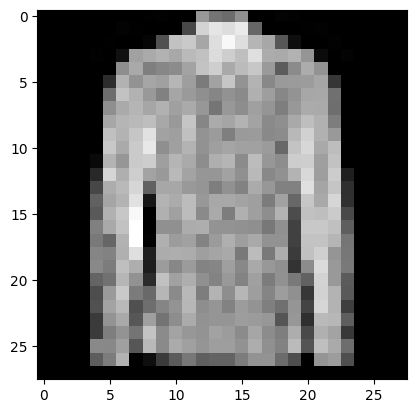

In [11]:
plt.imshow(train_images[112].reshape((28,28)), cmap = 'gray')

# Etapa 4: Construção do gerador

In [12]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # Total de neurônios na primeira camada oculta: 12544
  model.add(layers.BatchNormalization()) # Normalização dentro da camada oculta a fim de evitar overfitting (estratégia)
  model.add(layers.LeakyReLU()) # Função de ativação específica para GANS (variação da 'relu')

  model.add(layers.Reshape((7, 7, 256))) # Divide-se o 12544, pois como está trabalhando com camadas convolucionais é necessário ficar nesta dimensão,
                                         # como está na primeira camada densa (como fizemos no '28, 28, 1')

  model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False)) # Transpose para 'aumentar' a dimensionalidade da matriz
  # strides = 1 e padding = same indica que a matriz terá dimensão de '7,7,128(128=filtros)' ('7' e '7' (da Reshape) são referentes ao strides e '128' ao padding (same = '128'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False)) # Transpose para 'aumentar' a dimensionalidade da matriz
  # strides(o quanto a janela 'anda', em pixels) = 2 e padding = same indica que a matrix terá dimensão de '14,14,64' (explicação idem acima, mas baseado na camada acima)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
  # Função 'tanh' pois esta retorna valores entre '-1' e '1', conforme normalização acima. se tivesse normalizado entre '0' e '1' usaria sigmóide
  # Transpose para 'aumentar' a dimensionalidade da matriz
  # strides(o quanto a janela 'anda', em pixels) = 2 e padding = same indica que a matrix terá dimensão de '28,28,1' (explicação idem acima, mas baseado na camada acima)

  # As dimensões finais equivalem às da base de treinamento (28, 28, 1). É NECESSÁRIO que sejam iguais

  model.summary()

  return model

In [13]:
noise = tf.random.normal([1, 100]) # dimensões da matriz (100 porque input_shape = 100 na função)

In [14]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 1.5748962 , -1.2957289 , -0.34306115,  0.8434661 , -3.2298245 ,
        -0.69272405,  0.92413706,  0.95755064,  2.0019534 ,  0.3022033 ,
        -0.751717  ,  1.0377712 ,  0.63922024,  0.55501944,  0.4283924 ,
         0.95022595,  1.4180679 ,  0.97863674,  1.8711997 , -0.71747994,
        -2.4332218 , -0.07113314, -1.488242  , -0.92649925,  0.9688413 ,
        -0.66573673,  1.0089097 , -1.0850959 ,  0.8603487 , -0.93257254,
        -0.3133823 , -0.34810138, -0.14884183, -0.87835777, -1.131213  ,
         0.89012414,  0.4366149 ,  0.7719082 ,  0.01285336, -0.84062874,
         0.27339622, -2.245527  ,  1.3255793 , -0.835778  , -0.7754663 ,
         0.05851122,  1.7301499 ,  0.8839422 ,  1.0608267 , -0.5109247 ,
         1.4961044 , -0.5020761 ,  0.23763786, -1.1732197 ,  0.15987329,
        -1.6801877 ,  1.3438389 , -0.21355395, -1.2004365 , -1.9537578 ,
        -2.0020425 ,  1.4639488 ,  0.75214136, -0.6523224 ,  1.3048071 ,
 

In [15]:
generator = make_generator_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

In [16]:
generated_image = generator(noise, training = False)

In [17]:
generated_image.shape

TensorShape([1, 28, 28, 1])

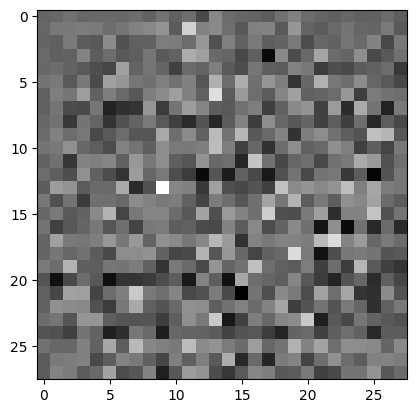

In [18]:
plt.imshow(generated_image[0,:,:,0], cmap = 'gray') # Busca somente a parte da imagem (28,28)

# Etapa 5: Construção do discriminador

In [19]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5,5), strides = (2,2), padding='same', input_shape=[28,28,1]))# Resultado será 14x14x64 (14 pois strides = 2 e 64 (qtde filtros) pois padding = 1)
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5,5), strides = (2,2), padding = 'same')) # Resultado será 7x7x128 (filtros)
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten()) # Resultado será 6272 = 7x7x128 (filtros)
  model.add(layers.Dense(1))

  model.summary()

  return model

In [20]:
discriminator = make_discriminator_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [21]:
decision= discriminator(generated_image, training = False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.0027295]], dtype=float32)>

# Etapa 6: Loss function para as duas redes

In [22]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # Indica que a saída não está escalonada em relação às camadas anteriores

In [23]:
# Função que calcula o erro para o Discriminator
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output) # comparando a imagem real com o valor '1'
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # comparando a imagem falsa com o valor '0'
  total_loss = real_loss + fake_loss # Indica que as duas redes irão aprender juntas
  return total_loss

In [24]:
# Função que calcula o erro para o Generator
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output) # Neste pondo compara-se o fake com o valor '1' (ones_like), que representa o real,
                                                               # pois o objetivo do gerador é quantificar o quão bem ele é em enganar o discriminador


In [25]:
generator_optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [26]:
# Salvar os pesos enquanto o treinamento é realizado, pois demora
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Etapa 7: Treinamento do modelo

In [27]:
epochs = 2
noise_dim = 100
num_examples_to_generate = 16

In [28]:
# Geração de 16 imagens randômicas
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [29]:
batch_size

256

In [30]:
@tf.function # Código para o tensorflow saber que esta parte será processada dentro de um grafo do tensorflow
def train_steps(images):
  noise = tf.random.normal([batch_size, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # Chamar o gerador e passar os números aleatórios para gerar as imagens fake
    generated_images = generator(noise, training = True)

    # Passar para o discriminador as imagens reais e falsas para fazer a classificação
    # Retornando o valor do array numpay. será retornado número para real e outro para fake
    real_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    # Calcular a loss para o gerador e discriminador
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  # Calcular o gradiente das losses para atualizar os pesos
  # Descobrir se vai aumentar ou diminuir o valor dos pesos para chegar ao mínimo global
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  # Aplicar os otimizadores e atualizar os pesos
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [31]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_steps(image_batch)

    display.clear_output(wait = True)
    generate_and_save_images(generator, epoch + 1, seed)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

  display.clear_output(wait = True)
  generate_and_save_images(generator, epoch + 1, seed)

In [32]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training = False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

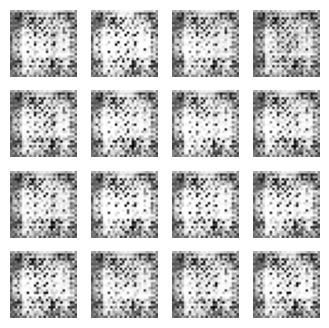

In [33]:
train(train_dataset, epochs)

In [34]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [35]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))